In [22]:
from lib import *

import matplotlib.font_manager as font_manager
font_dir = ["/Users/jenna/Downloads/Lato"]
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
plt.rcParams["font.family"] = "Lato"

from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

## Outliers

In [41]:
customer_behaviors = pd.read_csv('data/customer_behaviors.csv')
offer_transcripts = pd.read_csv('data/offer_transcripts.csv')

<AxesSubplot: xlabel='money_spent'>

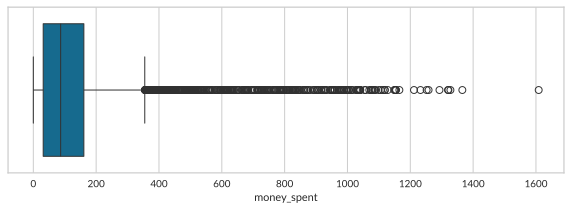

In [25]:
fig, ax = plt.subplots(figsize=(10,3), dpi = 96)
sns.boxplot(data = customer_behaviors, x = 'money_spent')

In [26]:
customer_behaviors['money_spent'].describe()

count    14825.000000
mean       117.028155
std        129.965016
min          0.000000
25%         31.450000
50%         87.040000
75%        160.900000
max       1608.690000
Name: money_spent, dtype: float64

The 0.75 quantile is only $163, while the maximum is $1608. This means that there are some significant outliers that are spending way more than the majoritiy of the customers. We can remove the top 2.5 % of spenders. 

In [27]:
# Removing rows with customers who's spending falls into the top 2.5%
q = customer_behaviors['money_spent'].quantile(0.975)
top_spenders_outliers = customer_behaviors[customer_behaviors['money_spent'] >= q]
customers_to_keep = customer_behaviors[customer_behaviors['money_spent'] < q]
print('Number of rows removed:', top_spenders_outliers.shape[0])

Number of rows removed: 371


The received column needs to be dropped from the customer_behavior data. The customer did not decide whether or not to receive the offer. Starbucks decided who to send the offers too. 

In [28]:
customers_df = customers_to_keep.drop('received', axis = 1)
customers_df.set_index(['id'], inplace = True)

### Scaling

In [29]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
scaled = sc.fit_transform(customers_df)
scaled_features = pd.DataFrame(data = scaled, columns = customers_df.columns.values)
scaled_features.head()

,completed,viewed,transactions,money_spent
0,-0.733105,-2.599203,-1.024312,-0.300967
1,0.538502,0.504509,-0.247472,0.686965
2,-0.097302,-0.271419,-1.024312,-0.532518
3,1.810108,2.056364,-1.024312,-0.788328
4,-0.733105,-1.047347,-0.830102,-1.038253


## Baseline Model

In [30]:
kmeans = KMeans(random_state = 42)
kmeans.fit_transform(scaled_features)

print('Silhouette Score:', silhouette_score(scaled_features, labels = kmeans.labels_).round(2))

Silhouette Score: 0.25


The Silhouette score with the default 4 clusters is 0.25. The Silhouette score ranges from -1 to 1 so 0.25 isn't bad, but could be better. 

### Finding ideal number of clusters (k)

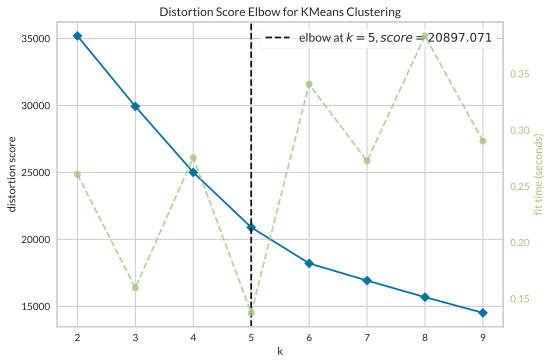

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
from yellowbrick.cluster import KElbowVisualizer
# Instantiate the clustering model and visualizer
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,10))
 
visualizer.fit(scaled_features)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Trying the algorithm with k = 5

In [32]:
kmeans = KMeans(n_clusters = 5, random_state = 42)
kmeans.fit_transform(scaled_features)

print('Silhouette Score:', silhouette_score(scaled_features, labels = kmeans.labels_).round(2))

Silhouette Score: 0.28


The Silhouette score is 0.28. 

#### Updating the model with PCA
PCA is a technique that helps us reduce the dimension of a dataset. When we run PCA on a data frame, new components are created. These components explain the maximum variance in the model.

([<matplotlib.axis.XTick at 0x29d695650>,
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

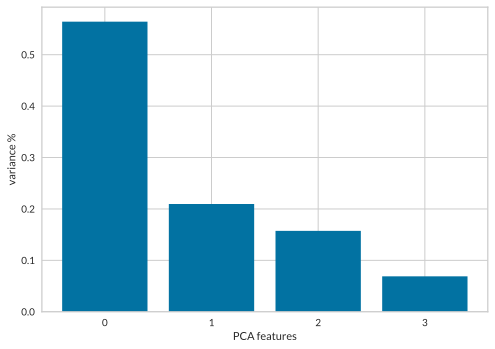

In [33]:
pca = PCA()
pca.fit(scaled_features)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

In [34]:
np.set_printoptions(suppress=True)
print(pca.explained_variance_ratio_)

[0.5641604  0.20955881 0.15730168 0.0689791 ]


Here, we can see that the first **2** features (0 and 1) account for around 77% of all of the variance. Let's update the data with the PCA components:

In [35]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(scaled_features)
PCA_components = pd.DataFrame(principalComponents)


Now, we can determine the ideal number of clusters in a K-means algorithm.

### Optimal Number of Clusters

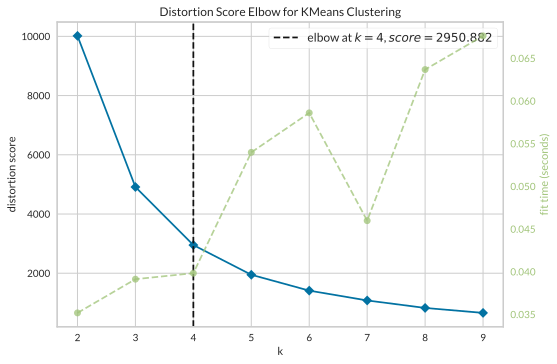

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [36]:
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,10))
 
visualizer.fit(PCA_components.iloc[:,:1])      # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure  # Finalize and render the figure

Based on silhouette score, the ideal number of clusters is 4. 

In [88]:
kmeans = KMeans(n_clusters = 5, random_state = 42)
kmeans.fit_transform(PCA_components.iloc[:,:1])

customer_with_clusters = customers_df.assign(cluster = kmeans.labels_)
print(customer_with_clusters.value_counts('cluster').sort_index())
print('Silhouette Score:', silhouette_score(PCA_components.iloc[:,:1], labels = kmeans.labels_).round(2))

cluster
0    1379
1    3538
2    2933
3    3090
4    3514
dtype: int64
Silhouette Score: 0.54


In [89]:
customers_df.head()

,completed,viewed,transactions,money_spent
id,,,,
0610b486422d4921ae7d2bf64640c50b,1,0,3,77.01
78afa995795e4d85b5d9ceeca43f5fef,3,4,7,159.27
e2127556f4f64592b11af22de27a7932,2,3,3,57.73
389bc3fa690240e798340f5a15918d5c,5,6,3,36.43
2eeac8d8feae4a8cad5a6af0499a211d,1,2,4,15.62


In [90]:
customer_with_clusters.head()

,completed,viewed,transactions,money_spent,cluster
id,,,,,
0610b486422d4921ae7d2bf64640c50b,1,0,3,77.01,3
78afa995795e4d85b5d9ceeca43f5fef,3,4,7,159.27,4
e2127556f4f64592b11af22de27a7932,2,3,3,57.73,1
389bc3fa690240e798340f5a15918d5c,5,6,3,36.43,2
2eeac8d8feae4a8cad5a6af0499a211d,1,2,4,15.62,3


**0.54** is way better than 0.28. <br>
To further test this, we can run a quick regression model to ensure the accruarcy. 

In [70]:
# Split data for train and test
X = scaled
Y = customer_with_clusters['cluster']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.24, random_state = 42)

In [71]:
# Multiclass logistic regression
clf = LogisticRegression()
clf.fit(x_train, y_train)

# Check test accurracy
y_predict_log = clf.predict(x_test)
acc_score_log = accuracy_score(y_test, y_predict_log) * 100
print("Test accuracy:", acc_score_log.round(2), "%")

Test accuracy: 99.34 %


In [72]:
# K-Nearest Neighbors Classificaiton
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(x_train, y_train)

# Check test accuracy
y_predict_knn = knn.predict(x_test)
acc_score_knn = accuracy_score(y_test, y_predict_knn) * 100
print("Test accuracy:", acc_score_knn.round(2), "%")

Test accuracy: 97.43 %


---------------
## Initial Cluster Analysis

In [73]:
# Calculating the relative performace of cluster's attribute values compared to all customers as a population
cluster_mean = customer_with_clusters.groupby('cluster').mean()
population_mean = customer_with_clusters.mean()
relative_importance = (cluster_mean / population_mean[0 :-1]) - 1

# Reordering to see the importance of each cluster
importance_ranking = relative_importance.sum(axis = 1).sort_values(ascending = False).index.values
relative_importance = relative_importance.reindex(importance_ranking)

print("Cluster Importance Rankings:", importance_ranking)

Cluster Importance Rankings: [0 2 4 1 3]


In [74]:
# Merging the cluster dataframe with the customer beahvior 
new = pd.merge(customer_with_clusters, customers_to_keep['received'], 
               left_index = True, right_index = True)

# Getting the means for each cluster for easy analysis
cluster_df= new.groupby('cluster').mean().round(2)

cluster_metrics = cluster_df.reindex(importance_ranking)
cluster_metrics

,completed,viewed,transactions,money_spent,received
cluster,,,,,
0,4.44,4.62,14.83,249.22,5.26
2,3.54,4.00,11.44,165.00,4.85
4,2.52,3.43,8.98,107.82,4.45
1,1.39,3.08,6.32,59.36,4.24
3,0.27,2.39,3.78,19.03,4.08


### **Metrics for each Cluster**
To better understand each cluster of customers, we can do some feature engineering:
##### Offer Metrics 
- **Offer Completion Rate (comp_rate)** - The number of offers completed compared to the total number of offers received. Does just receiving an offer have any effect of a customer making a purchase?
- **Offer Viewing Rate (view_rate)** - The number of completed offers compared to the number of offers viewed. Does a customer actually looking at the offer lead to a purchase?
- **Offer Effectiveness (offer_eff)** - The number of offers used to make a purchase. (offers completed/transactions)
  
##### Transactional Metrics 
- **Frequency (freq)** - How often the customer made a transaction (purchase) during the offer campaign, both with or without an offer. This is the number of transactions divided by 30 days. The maxmimum time for an offer campaign is 714 hours, or 29.75 days.
- **Average Purchase Value (apv)** - Average money spent per transaction

In [77]:
# Offer metrics
cluster_metrics['view_rate'] = (cluster_df['completed'] / cluster_df['viewed']).round(2)
cluster_metrics['comp_rate'] = (cluster_df['completed'] / cluster_df['received']).round(2)
cluster_metrics['offer_eff'] = (cluster_df['completed'] / cluster_df['transactions']).round(2)

# Transactional metrics
cluster_metrics['freq'] = (cluster_df['transactions']).round(2)
cluster_metrics['apv'] = (cluster_df['money_spent'] / cluster_df['transactions']).round(2)

# # Redorder index by importance ranking
# cluster_summary = cluster_metrics.reindex(importance_ranking)
# cluster_summary = cluster_summary.drop(['completed', 'viewed', 'transactions', 'received'], axis = 1)

In [78]:
cluster_metrics

,completed,viewed,transactions,money_spent,received,view_rate,comp_rate,offer_eff,freq,apv
cluster,,,,,,,,,,
0,4.44,4.62,14.83,249.22,5.26,0.96,0.84,0.30,14.83,16.81
2,3.54,4.00,11.44,165.00,4.85,0.88,0.73,0.31,11.44,14.42
4,2.52,3.43,8.98,107.82,4.45,0.73,0.57,0.28,8.98,12.01
1,1.39,3.08,6.32,59.36,4.24,0.45,0.33,0.22,6.32,9.39
3,0.27,2.39,3.78,19.03,4.08,0.11,0.07,0.07,3.78,5.03


# Analysis of the Clusters

**Cluster 2 - The MVP of Customers**
-  These customers have spent over $200 on average. The have an overall offer completion rate of 82%. Of the offers viewed by this group, 95% of them were later completed. However, their offer effectiveness rate is about 30%, suggesting that while they do use most of the offers they receive, they will still make transactions (purchases) without them. 
- This cluster makes a purchase 14 times a month, which is every 2 or 3 days. 
- They spend an average of $16.43 per purchase.

**Cluster 0 - The High-Potentials**
- These customers have an offer completion rate of 68%. This cluster uses over two-thirds of the offers they receive, and continue the majority of their purchases (70%) without any offers. This means that this group will make purchases with or without an offer.
- This cluster makes around 10-11 purchases each month, which is every about every 3 days.
- They spend a little more than $13 on each purchase.
This cluster has the potential to evolve into MVPs since they do complete around 84% of the offers the receieve. 

**Cluster 3 - The Casual Customer**
- These customers have an offer completion rate of 44% with an offer effiencey rate of 24%. With a view rate of 59%, it's likely these customers don't pay much attention to the offers. This suggests that while they are highly responsive to offers, they will still make transactions (purchases) without them. 
- What's interesting is that of the 37% that receive and complete the offers, the offer view rate over 100%. This suggests that they will blindly use an offer. For those customers in this cluster that actually use the offers, while in line to place an order, they will most likely quickly scan to see if they have received an offer. If they have, they will blindly use it without actually viewing the offer itself. 
- These customers make a purchase 7.68 days each month, or a little more than once a week. When they do make a purchase, they spend, on average, the most out of all of the clusters - $18.10
- 

**Cluster 2 - The Least Likely Customer**
- This group has the lowest completion rate, viewing rate, and offer effectiveness. 
- They come in about once a week and spend around $ 6.86 on a purchase. 
- Future offers are not likely to effect this group.
****


In [85]:
offer_transcripts.rename(columns={'person': 'id'}, inplace=True)

In [86]:
clusters_ = customer_with_clusters.reset_index()
cluster_to_combine = clusters_[['id', 'cluster']]

In [87]:
# Merging the cluster dataframe with the customer beahvior 
full_clusters = pd.merge(customer_with_clusters, offer_transcripts, on = 'id')
full_clusters.head()

,id,completed,viewed,transactions,money_spent,cluster,event,hours_since_start,value_id,reward,channels,difficulty,duration,offer_type,offer_code,channels_code
0,0610b486422d4921ae7d2bf64640c50b,1,0,3,77.01,3,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"['web', 'email', 'mobile']",5,7,bogo,A,B
1,0610b486422d4921ae7d2bf64640c50b,1,0,3,77.01,3,offer completed,528,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"['web', 'email', 'mobile']",5,7,bogo,A,B
2,0610b486422d4921ae7d2bf64640c50b,1,0,3,77.01,3,offer received,504,3f207df678b143eea3cee63160fa8bed,0,"['web', 'email', 'mobile']",0,4,informational,C,B
3,78afa995795e4d85b5d9ceeca43f5fef,3,4,7,159.27,4,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"['web', 'email', 'mobile']",5,7,bogo,A,B
4,78afa995795e4d85b5d9ceeca43f5fef,3,4,7,159.27,4,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"['web', 'email', 'mobile']",5,7,bogo,A,B


In [79]:
offer_transcripts.rename(columns = 'person')

,person,event,hours_since_start,value_id,reward,channels,difficulty,duration,offer_type,offer_code,channels_code
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"['web', 'email', 'mobile']",5,7,bogo,A,B
1,ebe7ef46ea6f4963a7dd49f501b26779,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"['web', 'email', 'mobile']",5,7,bogo,A,B
2,f082d80f0aac47a99173ba8ef8fc1909,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"['web', 'email', 'mobile']",5,7,bogo,A,B
3,c0d210398dee4a0895b24444a5fcd1d2,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"['web', 'email', 'mobile']",5,7,bogo,A,B
4,57dd18ec5ddc46828afb81ec5977bef2,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"['web', 'email', 'mobile']",5,7,bogo,A,B
